In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statistics import mean, stdev

In [2]:
df = pd.read_excel("scCO2_CDK_full.xlsx")

In [3]:
drug_index_mapping = {}
drug_current_index = 1


for index, row in df.iterrows():
    drug = row['MOLECULEID']
        
    if drug not in drug_index_mapping:
        drug_index_mapping[drug] = drug_current_index
        drug_current_index += 1
    df.at[index, 'Ind'] = drug_index_mapping[drug]

In [4]:
X=df.drop(["SMILES", "MOLECULEID", "Solubility", "Ind"], axis=1)

In [5]:
y = df['Solubility']
y = y.astype(float)

In [6]:
unique_inds = df['Ind'].unique()

In [7]:
r2_scores = []
rmse_scores = []
mae_scores = []
average_relative_deviations = []

for i in range(5):
    ind_train, ind_test = train_test_split(unique_inds, test_size=0.20, random_state=i)

    train_indices = df[df['Ind'].isin(ind_train)].index
    test_indices = df[df['Ind'].isin(ind_test)].index

    x_train, y_train = X.loc[train_indices].values, y.loc[train_indices].values
    x_test, y_test = X.loc[test_indices].values, y.loc[test_indices].values

    model = catboost.CatBoostRegressor(silent=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    Y_pred_array = np.array(y_pred)
    Y_true_array = np.array(y_test)
    
    relative_deviation = (Y_true_array - Y_pred_array) / Y_true_array
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean()*100
    average_relative_deviations.append(average_relative_deviation)

    print(f"Iteration {i}: RMSE = {rmse:.3f}, R2 = {r2:.3f}, MAE = {mae:.3f}, AARD = {average_relative_deviation:.3f}")

Iteration 0: RMSE = 0.894, R2 = 0.469, MAE = 0.658, AARD = 21.768
Iteration 1: RMSE = 0.947, R2 = 0.359, MAE = 0.784, AARD = 19.266
Iteration 2: RMSE = 0.829, R2 = 0.437, MAE = 0.664, AARD = 16.575
Iteration 3: RMSE = 0.853, R2 = 0.371, MAE = 0.686, AARD = 19.298
Iteration 4: RMSE = 0.741, R2 = 0.599, MAE = 0.561, AARD = 16.490


In [8]:
print("\nAverage performance of test set at 5 split")
print("Metric\tavg\tstdev")
print("R^2\t%.2f\t%.2f" % (mean(r2_scores), stdev(r2_scores)))
print("RMSE\t%.2f\t%.2f" % (mean(rmse_scores), stdev(rmse_scores)))
print("MAE\t%.2f\t%.2f" % (mean(mae_scores), stdev(mae_scores)))
print("AARD\t%.2f\t%.2f" % (mean(average_relative_deviations), stdev(average_relative_deviations)))


Average performance of test set at 5 split
Metric	avg	stdev
R^2	0.45	0.10
RMSE	0.85	0.08
MAE	0.67	0.08
AARD	18.68	2.21


In [9]:
#Final model

In [10]:
df = pd.read_excel('scCO2_CDK_clean.xlsx')

In [11]:
drug_index_mapping = {}
drug_current_index = 1


for index, row in df.iterrows():
    drug = row['MOLECULEID']
        
    if drug not in drug_index_mapping:
        drug_index_mapping[drug] = drug_current_index
        drug_current_index += 1
    df.at[index, 'Ind'] = drug_index_mapping[drug]

In [12]:
X=df.drop(["SMILES", "MOLECULEID", "Solubility", "Ind"], axis=1)

In [13]:
y = df['Solubility']
y = y.astype(float)
X=X.values

In [14]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [15]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
Y_pred, Y_true = [], []
average_relative_deviations = []

for train_index, test_index in cv.split(X, groups=df['Ind']):
    x_train = X[train_index]
    x_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    model = CatBoostRegressor(silent=True, learning_rate = 0.016, depth = 7, subsample = 0.299,
                           colsample_bylevel = 0.805, min_data_in_leaf = 88)
    model.fit(x_train, y_train)
    Y_pred.extend(model.predict(x_test))
    Y_true.extend(y_test)
    
    Y_pred_array = np.array(Y_pred)
    Y_true_array = np.array(Y_true)

    relative_deviation = (Y_true_array - Y_pred_array) / Y_true_array
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean()*100
    average_relative_deviations.append(average_relative_deviation)
    
print('R^2 = {}'.format(round(metrics.r2_score(Y_true, Y_pred),2)))
print('RMSE = {}'.format(round(metrics.mean_squared_error(Y_true, Y_pred, squared=False),2)))
print('MAE = {}'.format(round(mean_absolute_error(Y_true, Y_pred),2)))
print('AARD =', round(sum(average_relative_deviations) / len(average_relative_deviations),2))

R^2 = 0.57
RMSE = 0.69
MAE = 0.55
AARD = 14.21


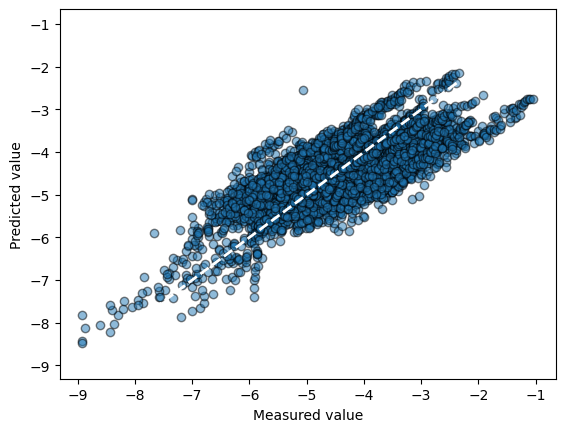

In [17]:
fig, ax = plt.subplots()
ax.scatter(Y_true, Y_pred, edgecolors=(0, 0, 0), alpha=0.5)
ax.plot([y.min(), y.max()], [y.min(), y.max()], "w--", lw=2)
ax.set_xlabel("Measured value")
ax.set_ylabel("Predicted value")
plt.show()